In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy

In [2]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x: literal_eval(x) if pd.notnull(x) else 'Not-Funded')
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [3]:
fund_df = pubs_author_funder[['funder_country','author_country','year']]
fund_df = fund_df[fund_df['funder_country']!='Not-Funded']
fund_df['funder_country']=fund_df['funder_country'].apply(lambda x:list(set(x)))
fund_df['author_country']=fund_df['author_country'].apply(lambda x:list(set(x)))
fund_df.head()

,funder_country,author_country,year
0,[Turkey],[Turkey],2009
1,[United States],"[United States, France]",2009
2,[Russia],[Russia],2009
3,[Spain],[Spain],2009
4,[Spain],"[Spain, Germany]",2009


In [4]:
fund_df=fund_df.explode('funder_country')
fund_df.head()

,funder_country,author_country,year
0,Turkey,[Turkey],2009
1,United States,"[United States, France]",2009
2,Russia,[Russia],2009
3,Spain,[Spain],2009
4,Spain,"[Spain, Germany]",2009


In [5]:
def assign_type(fund,author):
    if (fund in author) and (len(author)==1):
        type='Domestic'
    elif (fund in author) and (len(author)>1):
        type='Collaboration'
    else:
        type='Foreign'
    return type
fund_df['type']=fund_df[['funder_country','author_country']].apply(lambda x: assign_type(x.funder_country,x.author_country),axis=1)
fund_df.head()

,funder_country,author_country,year,type
0,Turkey,[Turkey],2009,Domestic
1,United States,"[United States, France]",2009,Collaboration
2,Russia,[Russia],2009,Domestic
3,Spain,[Spain],2009,Domestic
4,Spain,"[Spain, Germany]",2009,Collaboration


In [42]:
fund_df.head()

,funder_country,author_country,year,type
0,Turkey,[Turkey],2009,Domestic
1,United States,"[United States, France]",2009,Collaboration
2,Russia,[Russia],2009,Domestic
3,Spain,[Spain],2009,Domestic
4,Spain,"[Germany, Spain]",2009,Collaboration


In [30]:
cntry_type_year=fund_df.groupby(['funder_country','year','type']).size().reset_index(name='count')
cntry_type_year=cntry_type_year.pivot_table(index=['funder_country','year'],columns='type',values='count')
cntry_type_year=cntry_type_year.fillna(0)
cntry_type_year = cntry_type_year.div(cntry_type_year.sum(axis=1),axis=0).reset_index()
cntry_type_year.head()

type,funder_country,year,Collaboration,Domestic,Foreign
0,Afghanistan,2010,1.0,0.0,0.0
1,Afghanistan,2011,0.0,0.0,1.0
2,Afghanistan,2012,0.0,0.0,1.0
3,Afghanistan,2015,0.0,0.0,1.0
4,Afghanistan,2016,0.0,0.0,1.0


In [32]:
def plot_singlecountry(data):
    fig, ax = plt.subplots(figsize=(16,8))
    selfdomes=data.Domestic.values
    selfcoll=data.Collaboration.values
    ff=data.Foreign.values
    labels=np.arange(2009,2019)
    ax.bar(labels,selfdomes,label="Domestic")
    ax.bar(labels,selfcoll, bottom=selfdomes,label='Collaboration')
    ax.bar(labels,ff,bottom=selfdomes+selfcoll,label='Foreign')
    ax.legend(bbox_to_anchor=(1, 0.9),fontsize=15)
    plt.xticks(ticks=labels,labels=labels,rotation=45,horizontalalignment='right',
              fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Proportion of Funding",fontsize=20)
    return fig, ax

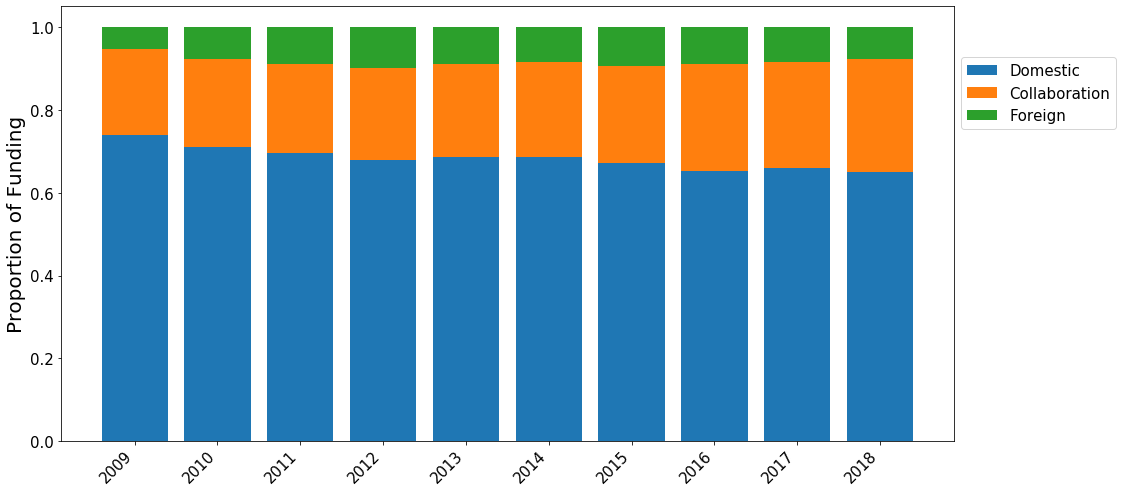

In [40]:
cntry='Japan'
cntry_filter = cntry_type_year[cntry_type_year.funder_country==cntry]
fig,ax=plot_singlecountry(cntry_filter)
filename=cntry+".png"
#plt.savefig(filename,bbox_inches='tight')

In [46]:
cntry_type

type,Collaboration,Domestic,Foreign,total
funder_country,,,,
Afghanistan,1.0,0.0,22.0,23.0
Albania,14.0,2.0,18.0,34.0
Algeria,1269.0,825.0,160.0,2254.0
Andorra,7.0,0.0,42.0,49.0
Angola,39.0,0.0,12.0,51.0
...,...,...,...,...
Venezuela,834.0,722.0,161.0,1717.0
Vietnam,4211.0,3313.0,1045.0,8569.0
Yemen,61.0,1.0,109.0,171.0


In [52]:
cntry_type[['Domestic','Collaboration','Foreign']].div(cntry_type['total'],axis=0)

type,Domestic,Collaboration,Foreign
funder_country,,,
Afghanistan,0.000000,0.043478,0.956522
Albania,0.058824,0.411765,0.529412
Algeria,0.366016,0.562999,0.070985
Andorra,0.000000,0.142857,0.857143
Angola,0.000000,0.764706,0.235294
...,...,...,...
Venezuela,0.420501,0.485731,0.093768
Vietnam,0.386626,0.491423,0.121951
Yemen,0.005848,0.356725,0.637427


In [6]:
cntry_type=fund_df.groupby(['funder_country','type']).size().reset_index(name='count')
cntry_type=cntry_type.pivot_table(index=['funder_country'],columns='type',values='count')
cntry_type['total']=cntry_type.sum(axis=1)
cntry_type=cntry_type.fillna(0)
cntry_type[['Domestic','Collaboration','Foreign']] = cntry_type[['Domestic','Collaboration','Foreign']].div(cntry_type['total'],axis=0)
cntry_type=cntry_type.reset_index()
cntry_type.head()

type,funder_country,Collaboration,Domestic,Foreign,total
0,Afghanistan,0.043478,0.000000,0.956522,23.0
1,Albania,0.411765,0.058824,0.529412,34.0
2,Algeria,0.562999,0.366016,0.070985,2254.0
3,Andorra,0.142857,0.000000,0.857143,49.0
4,Angola,0.764706,0.000000,0.235294,51.0


In [26]:
def plot_topncountry(data):
    fig, ax = plt.subplots(figsize=(16,8))
    selfdomes=data.Domestic.values
    selfcoll=data.Collaboration.values
    ff=data.Foreign.values
    labels=data.funder_country
    ax.bar(labels,selfdomes,label="Domestic",color="#0367A6")
    ax.bar(labels,selfcoll, bottom=selfdomes,label='Collaboration',color="#FFA522")
    ax.bar(labels,ff,bottom=selfdomes+selfcoll,label='Foreign',color="#F25F29")
    ax.legend(bbox_to_anchor=(1, 0.9),fontsize=15)
    plt.xticks(ticks=labels,labels=labels,rotation=45,horizontalalignment='right',
              fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Proportion of Funding",fontsize=20)
    return fig, ax

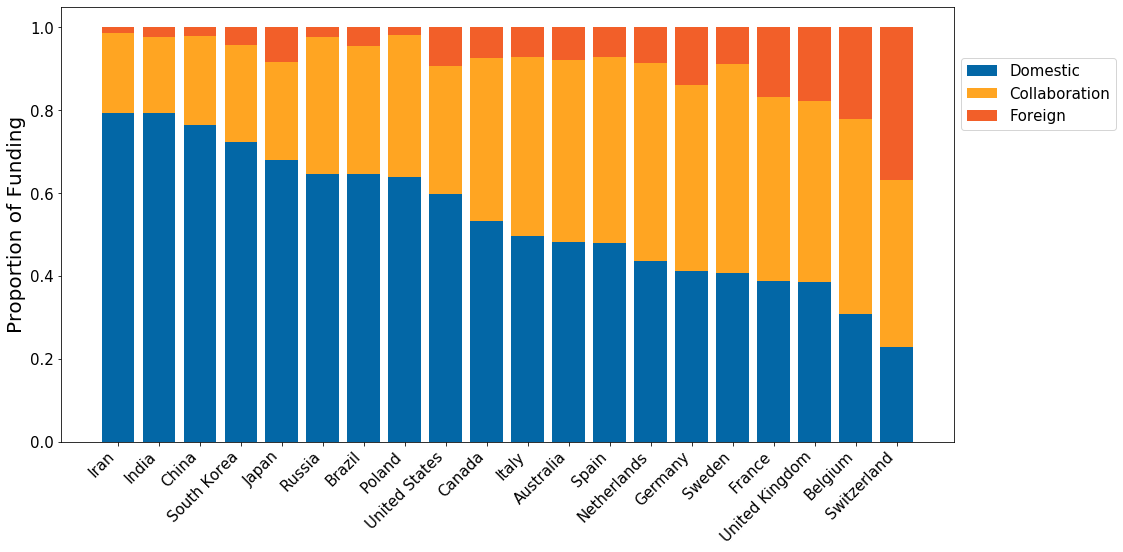

In [28]:
n=20
cntry_type=cntry_type[cntry_type.funder_country!='EU']
topn=cntry_type.sort_values(by='total',ascending=False).head(n)
topn=topn.sort_values(by='Domestic',ascending=False)
fig, ax = plot_topncountry(topn)
plt.savefig("providefund.png",format='png',bbox_inches="tight")

In [17]:
cntry_meta = pd.read_csv("country_metadata.csv",engine='python')
cntry_region=cntry_meta[['country','Region Name']]
cntry_region.head()

,country,Region Name
0,Afghanistan,Asia
1,Albania,Europe
2,Algeria,Africa
3,American-Samoa,Oceania
4,Andorra,Europe


In [19]:
cntry_type = cntry_type.merge(cntry_region, left_on='funder_country',right_on='country')
cntry_type.head()

,funder_country,Collaboration,Domestic,Foreign,total,country,Region Name
0,Afghanistan,0.043478,0.000000,0.956522,23.0,Afghanistan,Asia
1,Albania,0.411765,0.058824,0.529412,34.0,Albania,Europe
2,Algeria,0.562999,0.366016,0.070985,2254.0,Algeria,Africa
3,Andorra,0.142857,0.000000,0.857143,49.0,Andorra,Europe
4,Angola,0.764706,0.000000,0.235294,51.0,Angola,Africa


In [21]:
cntry_type['Region Name'].unique()

array(['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], dtype=object)